# Data preparation

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [189]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [60]:
import mne
import stats

In [3]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

In [4]:
raw = mne.io.read_raw_edf('data/Ears_lr1.edf', preload=True)

Extracting EDF parameters from /home/delta_c/EnW/Biotech_Researches/EEG_Event_Classification/data/Ears_lr1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 70999  =      0.000 ...   141.998 secs...


/tmp/ipykernel_2396/995447494.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'SAO2'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('data/Ears_lr1.edf', preload=True)


In [5]:
sample_rate = raw.info['sfreq']

In [14]:
raw.drop_channels(raw.ch_names[-5:])

Measurement date,"October 09, 2024 16:02:35 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [15]:
mapping = dict(zip(raw.ch_names, ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']))
raw.rename_channels(mapping)

Measurement date,"October 09, 2024 16:02:35 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [33]:
n_channels = len(raw.ch_names)

In [20]:
data = raw['data'][0].T
data.shape

(71000, 19)

# Searching events

In [6]:
stamps = pd.read_csv('data/click_timestamps1.csv')
stamps.head()

,Ear,Time
0,Left,2024-10-09 16:02:40.026203
1,Right,2024-10-09 16:02:42.027171
2,Left,2024-10-09 16:02:44.027530
3,Right,2024-10-09 16:02:46.027743
4,Left,2024-10-09 16:02:48.027924


In [7]:
left_stamps = [datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S.%f') for stamp in stamps[stamps['Ear'] == 'Left']['Time']]
right_stamps = [datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S.%f') for stamp in stamps[stamps['Ear'] == 'Right']['Time']]
right_stamps[:2]

[datetime.datetime(2024, 10, 9, 16, 2, 42, 27171),
 datetime.datetime(2024, 10, 9, 16, 2, 46, 27743)]

In [8]:
initial_stamp = datetime.strptime(datetime.strftime(raw.info['meas_date'], '%Y-%m-%d %H:%M:%S.%f'), '%Y-%m-%d %H:%M:%S.%f')
initial_stamp

datetime.datetime(2024, 10, 9, 16, 2, 35)

In [9]:
events = {
    'left': [round(sample_rate * (left_stamps[i] - initial_stamp).total_seconds()) for i in range(len(left_stamps))],
    'right': [round(sample_rate * (right_stamps[i] - initial_stamp).total_seconds()) for i in range(len(right_stamps))]
}
events['right']

[3514,
 5514,
 7514,
 9514,
 11514,
 13515,
 15515,
 17515,
 19515,
 21516,
 23516,
 25516,
 27516,
 29516,
 31517,
 33517,
 35517,
 37517,
 39518,
 41518,
 43518,
 45518,
 47518,
 49519,
 51519,
 53519,
 55519,
 57519,
 59520,
 61520,
 63520,
 65520,
 67520]

In [31]:
n_events = len(events['left'])

# Fetching windows

In [166]:
win = np.arange(int(-0.1 * sample_rate), int(0.1 * sample_rate))
len(win)

100

In [167]:
events.keys()

dict_keys(['left', 'right'])

In [168]:
trials_l = []
trials_r = []

for side in events.keys():
    for event in events[side]:
        for i in win:
            col = []
            for j in range(19):
                col.append(data[event + i][j] * 1e6)
                
            if side == 'right':
                trials_r.append(col)
            else:
                trials_l.append(col)
        
trials_l = np.array(trials_l)
trials_r = np.array(trials_r)

In [169]:
trials_l = trials_l.T.reshape((n_channels, len(win), n_events))
trials_r = trials_r.T.reshape((n_channels, len(win), n_events))

# Statistical research

The next code might be the most important in all notebook

Now we need to calculate the varinces on both sides and subtrack of them to (?gram) another. There will be values that have different signs

In [170]:
var_diffs = np.round(np.mean(stats.logvar(trials_l, axis=1), axis=1) - np.mean(stats.logvar(trials_r, axis=1), axis=1), 2)

print('Differences between variances')
for i in range(n_channels):
    print(f'{raw.ch_names[i]} : {var_diffs[i]}')

Differences between variances
FP1 : -0.21
FP2 : 0.28
F3 : 0.04
F4 : 0.08
C3 : 0.3
C4 : -0.0
P3 : 0.33
P4 : 0.15
O1 : 0.1
O2 : 0.23
F7 : -0.09
F8 : 0.46
T3 : 0.22
T4 : 0.25
T5 : 0.16
T6 : 0.17
Fz : -0.02
Cz : 0.16
Pz : 0.27


We're going to reach the thorouh separation of two stimuli and we need to check that our variances differs from one side of head to other to achieve this purpose. So, if we couldn't see quite good results we should change size or position of window and try previous steps again

The spectrogram could be helpful in situation, when we couldn't find the right position of the window. Previously we need to set the left initial point of the window to zero

In [171]:
w = gaussian(20, std=1, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(w, hop=1, fs=sample_rate, scale_to='magnitude')
Sx_l1 = SFT.stft(np.mean(trials_l[0, :, :], axis=1))
Sx_l2 = SFT.stft(np.mean(trials_r[0, :, :], axis=1))

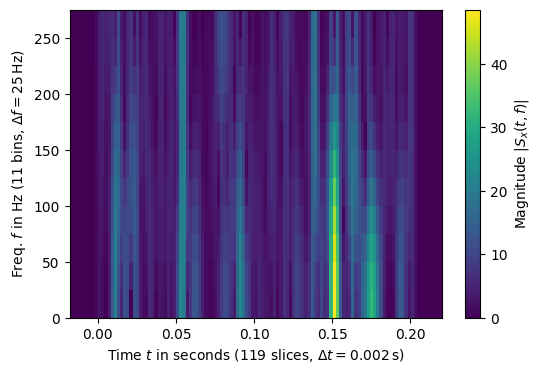

In [172]:
fig, ax = plt.subplots(figsize=(6., 4.))

im1 = ax.imshow(abs(Sx_l1), origin='lower', aspect='auto',
                 extent=SFT.extent(100), cmap='viridis')
ax.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(100)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)")

fig.colorbar(im1, label="Magnitude $|S_x(t, f)|$")
plt.show()

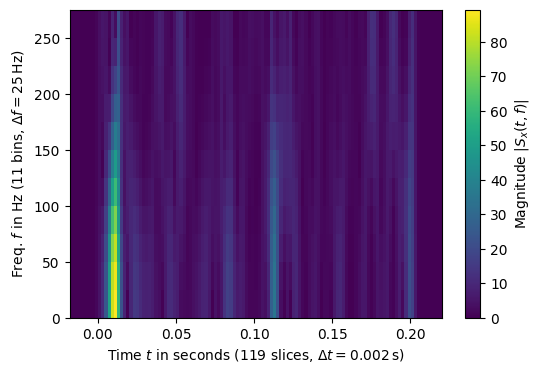

In [173]:
fig, ax = plt.subplots(figsize=(6., 4.))

im2 = ax.imshow(abs(Sx_l2), origin='lower', aspect='auto',
                 extent=SFT.extent(100), cmap='viridis')
ax.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(100)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)")

fig.colorbar(im2, label="Magnitude $|S_x(t, f)|$")
plt.show()

# Data transforming

The most magic part of the work

In [174]:
W = np.array([[ 0.05752722, -0.19712048, -0.0704473 , -0.20025526, -0.01879376,
         0.12123097,  0.33293908, -0.09450275,  0.05399266, -0.0138614 ,
         0.07649579,  0.18357042,  0.06032243, -0.0599483 , -0.0245716 ,
         0.06472738, -0.01172027,  0.12353227,  0.21192793],
       [ 0.05656163, -0.05602463, -0.00256536,  0.15149498,  0.15671692,
        -0.22824593, -0.15002825,  0.06530056,  0.12211465, -0.20354844,
        -0.03640206, -0.14486027,  0.13122859,  0.0317153 ,  0.15445949,
         0.0143024 ,  0.17770419, -0.12987388, -0.13383214],
       [ 0.009687  , -0.19036234,  0.03394341, -0.07889788, -0.37191805,
        -0.38748683, -0.34461784,  0.25820066,  0.21269164, -0.47661887,
         0.4527156 , -0.18707224,  0.03427245, -0.40984379, -0.01912187,
        -0.55102689,  0.08693864,  0.22153184,  0.04809895],
       [-0.00099497, -0.12736672,  0.04695344, -0.11272359,  0.11220638,
         0.13136718, -0.37117096, -0.01546613,  0.44334799, -0.14027671,
         0.22376946,  0.36095391, -0.31797144,  0.15154333, -0.32459843,
         0.16954411, -0.18524276,  0.20045299, -0.11047399],
       [-0.03328607, -0.07273104, -0.18360247, -0.04573949,  0.167078  ,
        -0.05529481,  0.10152502, -0.24906794,  0.32757255,  0.2923464 ,
         0.02702155, -0.02191097, -0.24396996,  0.24228252,  0.06287331,
        -0.0413808 , -0.01799875, -0.13733854, -0.05176213],
       [-0.01259886,  0.03646927,  0.08755716, -0.16089142, -0.00413583,
        -0.08944519,  0.13070571, -0.12934372,  0.05371178,  0.16806088,
        -0.24316861,  0.04987193,  0.29843446, -0.18027227, -0.18112894,
        -0.01482725, -0.04856398, -0.24753881, -0.03273983],
       [-0.07934601, -0.00953116,  0.37005641,  0.32775844,  0.17822673,
        -0.11104511, -0.06890314,  0.30151141, -0.29821897,  0.03942949,
        -0.09627048,  0.20318381,  0.33621487, -0.16271708, -0.28695804,
         0.05353952,  0.14543972,  0.03004476,  0.04422379],
       [-0.13407112, -0.02105625, -0.04171046,  0.3031797 , -0.17892016,
        -0.22618645, -0.09393714, -0.06710997,  0.08806788, -0.33007597,
        -0.169941  ,  0.16028216, -0.19025089,  0.24550542,  0.05037129,
         0.05792036, -0.07102958, -0.01661648,  0.05418165],
       [ 0.02183989,  0.05715135,  0.32732029, -0.11436938,  0.04411129,
         0.20762219, -0.09974819,  0.25462945,  0.28342261,  0.03680819,
        -0.3052951 , -0.03965843, -0.45519587,  0.36069605,  0.26554255,
        -0.24213939,  0.10062264, -0.10551372, -0.03300568],
       [ 0.08043846,  0.02952784,  0.08618553, -0.21940371,  0.187125  ,
         0.12402035,  0.38152969,  0.16789812, -0.11462338,  0.01154711,
         0.56602531,  0.31874151,  0.5909703 ,  0.11101907, -0.08236974,
        -0.21495007, -0.06768061, -0.15175213, -0.07489794],
       [-0.0320905 ,  0.16390742,  0.0814771 , -0.04302144,  0.06220123,
         0.00696897, -0.12061669, -0.06247969, -0.461099  ,  0.15011317,
        -0.08911058,  0.03527044, -0.21905585,  0.22742094, -0.19354389,
         0.14472453, -0.08193795, -0.24744205, -0.13652484],
       [-0.0628931 ,  0.18722789, -0.10015349, -0.0637029 , -0.00175722,
         0.11558439, -0.03152997,  0.10283078, -0.15672742,  0.09468028,
        -0.18381849,  0.15687894, -0.08257347, -0.14522501,  0.01825796,
        -0.16788481, -0.03446699, -0.0205165 ,  0.09694601],
       [-0.06638711,  0.0397932 , -0.06836142,  0.24108337, -0.10486565,
         0.51814403,  0.13705713, -0.32349672,  0.24112669, -0.32321107,
        -0.0136792 ,  0.14294875,  0.15196966, -0.13927888,  0.15500378,
        -0.057666  ,  0.15472077,  0.08904392, -0.06286992],
       [-0.06590807,  0.10859904,  0.29576548,  0.2127937 , -0.4820125 ,
         0.11818659,  0.35700592, -0.04582984, -0.14640609,  0.07570526,
         0.35191326, -0.53531041, -0.35129877,  0.20613794,  0.12256316,
         0.16449553,  0.22970106,  0.07185563,  0.12269964],
       [ 0.01470575,  0.00159708, -0.39356867, -0.13146875, -0.18183663,
        -0.21843117, -0.04406977, -0.00408851,  0.07546641,  0.06901584,
         0.35782427, -0.18549586,  0.02781184, -0.14912155, -0.13777004,
         0.4773133 , -0.25753575, -0.12744349,  0.04222141],
       [ 0.01882052, -0.17345838, -0.12265209,  0.06603022,  0.09917994,
         0.18339859, -0.39694167, -0.14422191,  0.00100814,  0.23766892,
        -0.18865994, -0.25233367, -0.07564796, -0.2952235 ,  0.06443329,
        -0.03426265,  0.03756386,  0.06624011,  0.07393578],
       [-0.16968283,  0.20048695, -0.07844149,  0.22767002,  0.1005713 ,
         0.1918199 ,  0.30935036,  0.01507843, -0.45917698,  0.44779675,
        -0.40671606, -0.35017536,  0.32574029,  0.4072282 ,  0.21525787,
         0.32586039, -0.02522778, -0.10915018,  0.03769331],
       [ 0.23165407,  0.12214589,  0.11686807,  0.11373646, -0.05233554,
         0.01847929, -0.04821726, -0.01130028, -0.11221075,  0.02043073,
         0.00959209, -0.04171748, -0.02326509,  0.03895739, -0.07885576,
        -0.12070943,  0.00963909,  0.06616875,  0.00234526],
       [ 0.08758271, -0.05664203, -0.33388336, -0.40860464, -0.12568512,
         0.06595953,  0.03308937, -0.04100695, -0.17055076, -0.03158351,
        -0.01833496, -0.08171182, -0.11846913, -0.18882989,  0.24553035,
         0.1295342 ,  0.0867337 ,  0.29683539, -0.05157026]])

In [175]:
trials_filt = {'left': stats.bandpass(trials_l, 2, 15, sample_rate),
               'right': stats.bandpass(trials_r, 2, 15, sample_rate)}

In [176]:
trials_csp = {'left': stats.apply_mix(W, trials_filt['left']),
              'right': stats.apply_mix(W, trials_filt['right'])}

In [177]:
trials_logvar = {'left': stats.logvar(trials_csp['left'], axis=1),
                 'right': stats.logvar(trials_csp['right'], axis=1)}

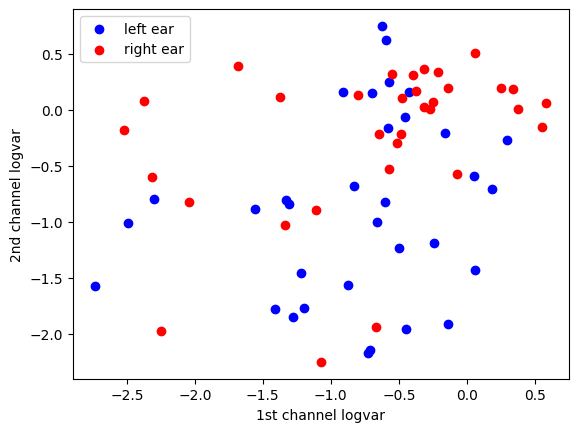

In [194]:
plt.scatter(trials_logvar['left'][3,:], trials_logvar['left'][1, :], c='blue')
plt.scatter(trials_logvar['right'][3,:], trials_logvar['right'][1, :], c='red')
plt.xlabel('1st channel logvar')
plt.ylabel('2nd channel logvar')
plt.legend(['left ear', 'right ear'])
plt.show()

**LDA**

In [181]:
trials_logvar['left'].shape

(19, 33)

In [182]:
X = np.zeros((n_events * 2, n_channels))
X[:n_events, :] = trials_logvar['left'].T
X[n_events:, :] = trials_logvar['right'].T 
y = np.array([0] * n_events + [1] * n_events)

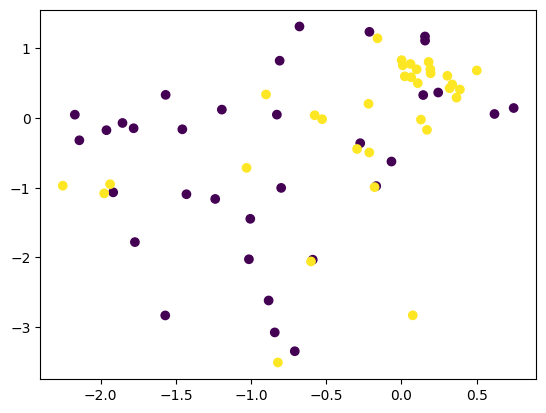

In [203]:
plt.scatter(X[:, 1], X[:, 2], c=y)

In [185]:
LDA = LinearDiscriminantAnalysis()

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [191]:
LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)

In [192]:
print(f'Accuracy is {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy is 100.00%
